In [1]:
from collections import Counter
import pandas as pd
import numpy as np
import tqdm
import pickle
import matplotlib.pyplot as plt
from Bio.PDB import *
from rdkit import Chem
import os
import time
import shutil
from Bio.SeqUtils import seq1
import gzip
import tarfile
import sys
import random
from rdkit.Chem import rdFreeSASA
from rdkit import Chem
from rdkit.Chem.Descriptors import MolWt
import urllib
from lxml import etree
import requests as r
from Bio import SeqIO
from io import StringIO
from sklearn.cluster import DBSCAN
from scipy.spatial import distance
from sklearn.metrics import pairwise_distances
import scipy.stats as ss
from scipy.interpolate import interpn
import matplotlib.colors as colors
import seaborn as sns
from rdkit.Chem import AllChem
from signaturizer import Signaturizer

In [2]:
docking = pd.read_csv("/slgpfs/projects/irb35/agimeno/MurD/docking_MurD/structures/SagaMurD_Frag373/docking_scores_and_accessibilities_and_pocket_edist.tsv", sep='\t')

positives = docking.loc[docking['class'] == 1].reset_index(drop=True)
negatives = docking.loc[docking['class'] == 0].reset_index(drop=True)

random.seed(42)

positives = sorted(random.sample(sorted(positives['smiles']), 5000))
negatives = sorted(random.sample(sorted(negatives['smiles']), 5000))

pocketvec = pd.read_csv("/aloy/home/acomajuncosa/MurD/GitHub/osa-murd/pocketvec/PDB/pocketvec_molecules.tsv", sep='\t', names=['PDB', 'InChI'])['InChI']
pocketvec = sorted([Chem.MolToSmiles(Chem.MolFromInchi(i)) for i in pocketvec])

In [7]:
docking

,title,score,pocket_edist,smiles,accessibility,MolWt,score/MolWt,class
0,D396-0181,-18.85070,0.467998,CC1(C)Cc2c(C#N)c(SCC(=O)Nc3ccc4ccccc4c3)nc(N3C...,0.404,488.61,-0.038580,0
1,8009-0167,-12.21080,2.917876,CC(CBr)n1ncnn1,0.157,191.03,-0.063921,0
2,5044-0010,-7.59264,9.114287,CCCCS(=O)(=O)N=C1NCN(CC(=O)[O-])CN1,0.325,277.33,-0.027378,0
3,N037-0036,-15.97440,2.293551,CC1CCC2C(C)C3CCC4(O)C(CC5C4CC(O)C4CC(O)CCC45C)...,0.320,431.66,-0.037007,0
4,3399-0213,-12.90590,7.442374,Cc1[nH]c(=S)[nH]c(=O)c1CCCO,0.407,200.26,-0.064446,0
...,...,...,...,...,...,...,...,...
300522,L426-0625,-10.09850,1.499124,CCCCNC(=O)C1(c2ccc(NS(=O)(=O)c3ccc(OC)c(OC)c3)...,0.349,446.57,-0.022613,0
300523,F294-0550,-7.24148,3.667831,CCCCN(CC)c1ccc(NS(=O)(=O)c2ccc(F)c(F)c2)cc1C(=O)O,0.296,412.46,-0.017557,0
300524,F295-0500,-11.27420,3.574957,CCN(CCN(C)C)c1ccc(C(=O)O)cc1NS(=O)(=O)c1ccc(C)...,0.358,419.55,-0.026872,0
300525,R052-1647,-16.72900,0.545912,Nc1c(Br)cc(NS(=O)(=O)c2ccccc2)cc1Br,0.142,406.10,-0.041194,1


In [149]:
spaces = ['A2', 'A4']
fps_positives = {}
fps_negatives = {}
fps_pocketvec = {}

for space in spaces:
    
    # Positives
    sign = Signaturizer(space)
    results_positives = sign.predict(positives, save_mfp=True)
    fps_positives[space] = results_positives.signature
    if 'Morgan' not in fps_positives:
        fps_positives['Morgan'] = results_positives.mfp
    
    # Negatives
    sign = Signaturizer(space)
    results_negatives = sign.predict(negatives, save_mfp=True)
    fps_negatives[space] = results_negatives.signature
    if 'Morgan' not in fps_negatives:
        fps_negatives['Morgan'] = results_negatives.mfp
        
        
    # PocketVec
    sign = Signaturizer(space)
    results_pocketvec = sign.predict(pocketvec, save_mfp=True)
    fps_pocketvec[space] = results_pocketvec.signature
    if 'Morgan' not in fps_pocketvec:
        fps_pocketvec['Morgan'] = results_pocketvec.mfp

In [150]:
dist_pos_pos = {}
dist_pos_neg = {}
dist_pocketvec_pocketvec = {}
dist_pocketvec_neg = {}
dist_neg_neg = {}



spaces = ['A2', 'A4', 'Morgan']
for space in tqdm.tqdm(spaces):
    
    # Metric
    if space == 'Morgan':
        metric = 'jaccard'
    else:
        metric = 'cosine'
        
    # Calculate distances
    dist_pos_pos[space] = np.array([j for i in pairwise_distances(fps_positives[space], metric=metric) for j in i])
    dist_neg_neg[space] = np.array([j for i in pairwise_distances(fps_negatives[space], metric=metric) for j in i])
    dist_pos_neg[space] = np.array([j for i in pairwise_distances(fps_positives[space], fps_negatives[space], metric=metric) for j in i])
    dist_pocketvec_pocketvec[space] = np.array([j for i in pairwise_distances(fps_pocketvec[space], metric=metric) for j in i])
    dist_pocketvec_neg[space] = np.array([j for i in pairwise_distances(fps_pocketvec[space], fps_negatives[space], metric=metric) for j in i])

 67%|██████▋   | 2/3 [00:15<00:07,  7.48s/it]/home/acomajuncosa/programs/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/acomajuncosa/programs/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/acomajuncosa/programs/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/acomajuncosa/programs/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/acomajuncosa/programs/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.

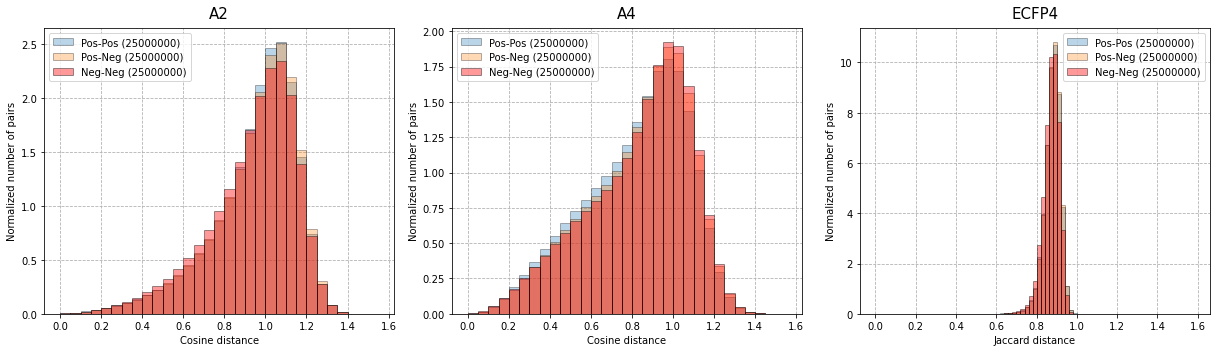

In [151]:
fig, ax = plt.subplots(1, 3, figsize=(17,5))


space = 'A2'
ax[0].set_title(space, pad=10, size=15)
ax[0].grid(linestyle='--')

ax[0].hist(dist_pos_pos[space], ec='k', density=True, 
           zorder=2, label='Pos-Pos (' + str(len(dist_pos_pos[space])) + ')', bins=[i for i in np.arange(0, 1.6, 0.05)], alpha=0.3)

ax[0].hist(dist_pos_neg[space], ec='k', density=True, 
           zorder=2, label='Pos-Neg (' + str(len(dist_pos_neg[space])) + ')', bins=[i for i in np.arange(0, 1.6, 0.05)], alpha=0.3)

ax[0].hist(dist_neg_neg[space], ec='k', density=True, 
           zorder=2, label='Neg-Neg (' + str(len(dist_neg_neg[space])) + ')', bins=[i for i in np.arange(0, 1.6, 0.05)], alpha=0.4, color='red')

ax[0].set_xlabel("Cosine distance")
ax[0].set_ylabel("Normalized number of pairs")
ax[0].legend()




space = 'A4'
ax[1].set_title(space, pad=10, size=15)
ax[1].grid(linestyle='--')

ax[1].hist(dist_pos_pos[space], ec='k', density=True, 
           zorder=2, label='Pos-Pos (' + str(len(dist_pos_pos[space])) + ')', bins=[i for i in np.arange(0, 1.6, 0.05)], alpha=0.3)

ax[1].hist(dist_pos_neg[space], ec='k', density=True, 
           zorder=2, label='Pos-Neg (' + str(len(dist_pos_neg[space])) + ')', bins=[i for i in np.arange(0, 1.6, 0.05)], alpha=0.3)

ax[1].hist(dist_neg_neg[space], ec='k', density=True, 
           zorder=2, label='Neg-Neg (' + str(len(dist_neg_neg[space])) + ')', bins=[i for i in np.arange(0, 1.6, 0.05)], alpha=0.4, color='red')

ax[1].set_xlabel("Cosine distance")
ax[1].set_ylabel("Normalized number of pairs")
ax[1].legend()


space = 'Morgan'
ax[2].set_title("ECFP4", pad=10, size=15)
ax[2].grid(linestyle='--')


ax[2].hist(dist_pos_pos[space], ec='k', density=True, 
           zorder=2, label='Pos-Pos (' + str(len(dist_pos_pos[space])) + ')', bins=[i for i in np.arange(0, 1.0001, 0.02)], alpha=0.3)

ax[2].hist(dist_pos_neg[space], ec='k', density=True, 
           zorder=2, label='Pos-Neg (' + str(len(dist_pos_neg[space])) + ')', bins=[i for i in np.arange(0, 1.0001, 0.02)], alpha=0.3)

ax[2].hist(dist_neg_neg[space], ec='k', density=True, 
           zorder=2, label='Neg-Neg (' + str(len(dist_neg_neg[space])) + ')', bins=[i for i in np.arange(0, 1.6, 0.02)], alpha=0.4, color='red')

ax[2].set_xlabel("Jaccard distance")
ax[2].set_ylabel("Normalized number of pairs")
ax[2].legend()

plt.tight_layout()
# plt.savefig("/aloy/home/acomajuncosa/MurD/GitHub/osa-murd/pocketvec/PDB/images/molecular_similarities/docking_comparisons.png", dpi=300)
plt.show()

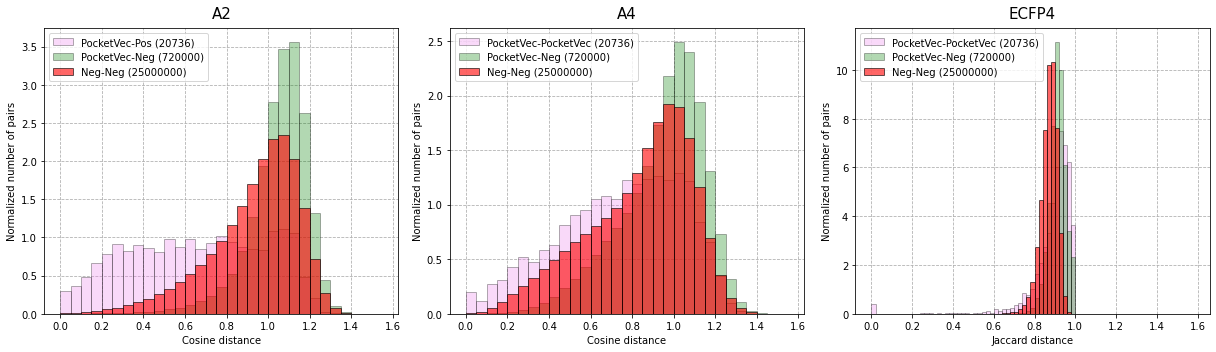

In [152]:
fig, ax = plt.subplots(1, 3, figsize=(17,5))


space = 'A2'
ax[0].set_title(space, pad=10, size=15)
ax[0].grid(linestyle='--')
ax[0].hist(dist_pocketvec_pocketvec[space], ec='k', density=True, 
           zorder=2, label='PocketVec-Pos (' + str(len(dist_pocketvec_pocketvec[space])) + ')', bins=[i for i in np.arange(0, 1.6, 0.05)], alpha=0.3, color='violet')

ax[0].hist(dist_pocketvec_neg[space], ec='k', density=True, 
           zorder=2, label='PocketVec-Neg (' + str(len(dist_pocketvec_neg[space])) + ')', bins=[i for i in np.arange(0, 1.6, 0.05)], alpha=0.3, color='green')

ax[0].hist(dist_neg_neg[space], ec='k', density=True, 
           zorder=2, label='Neg-Neg (' + str(len(dist_neg_neg[space])) + ')', bins=[i for i in np.arange(0, 1.6, 0.05)], alpha=0.6, color='red')

ax[0].set_xlabel("Cosine distance")
ax[0].set_ylabel("Normalized number of pairs")
ax[0].legend()




space = 'A4'
ax[1].set_title(space, pad=10, size=15)
ax[1].grid(linestyle='--')


ax[1].hist(dist_pocketvec_pocketvec[space], ec='k', density=True, 
           zorder=2, label='PocketVec-PocketVec (' + str(len(dist_pocketvec_pocketvec[space])) + ')', bins=[i for i in np.arange(0, 1.6, 0.05)], alpha=0.3, color='violet')

ax[1].hist(dist_pocketvec_neg[space], ec='k', density=True, 
           zorder=2, label='PocketVec-Neg (' + str(len(dist_pocketvec_neg[space])) + ')', bins=[i for i in np.arange(0, 1.6, 0.05)], alpha=0.3, color='green')

ax[1].hist(dist_neg_neg[space], ec='k', density=True, 
           zorder=2, label='Neg-Neg (' + str(len(dist_neg_neg[space])) + ')', bins=[i for i in np.arange(0, 1.6, 0.05)], alpha=0.6, color='red')


ax[1].set_xlabel("Cosine distance")
ax[1].set_ylabel("Normalized number of pairs")
ax[1].legend()


space = 'Morgan'
ax[2].set_title("ECFP4", pad=10, size=15)
ax[2].grid(linestyle='--')


ax[2].hist(dist_pocketvec_pocketvec[space], ec='k', density=True, 
           zorder=2, label='PocketVec-PocketVec (' + str(len(dist_pocketvec_pocketvec[space])) + ')', bins=[i for i in np.arange(0, 1.0001, 0.02)], alpha=0.3, color='violet')

ax[2].hist(dist_pocketvec_neg[space], ec='k', density=True, 
           zorder=2, label='PocketVec-Neg (' + str(len(dist_pocketvec_neg[space])) + ')', bins=[i for i in np.arange(0, 1.0001, 0.02)], alpha=0.3, color='green')

ax[2].hist(dist_neg_neg[space], ec='k', density=True, 
           zorder=2, label='Neg-Neg (' + str(len(dist_neg_neg[space])) + ')', bins=[i for i in np.arange(0, 1.6, 0.02)], alpha=0.6, color='red')


ax[2].set_xlabel("Jaccard distance")
ax[2].set_ylabel("Normalized number of pairs")
ax[2].legend()

plt.tight_layout()
# plt.savefig("/aloy/home/acomajuncosa/MurD/GitHub/osa-murd/pocketvec/PDB/images/molecular_similarities/pocketvec_comparisons.png", dpi=300)
plt.show()

In [111]:
data = np.array([i for i in fps_positives[space]] + [i for i in fps_negatives[space]] + [i for i in fps_pocketvec[space]])
# colors = np.array(["red" for i in fps_positives[space]] + ["blue" for i in fps_negatives[space]] + ["violet" for i in fps_pocketvec[space]])

In [113]:
from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.decomposition import PCA

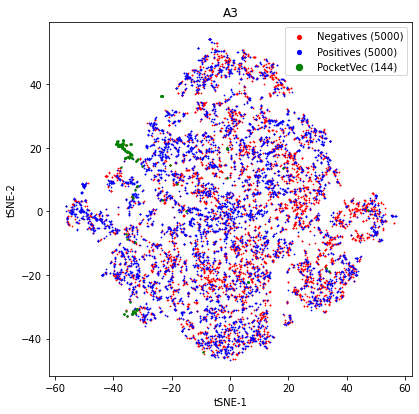

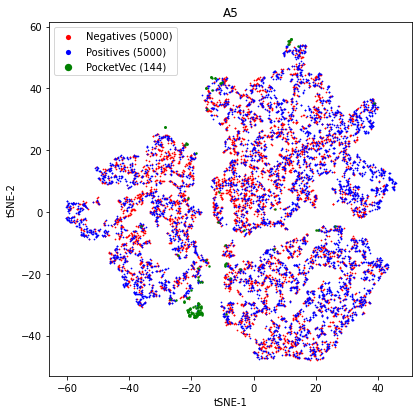

In [120]:
for space in ['A3', 'A5']:
    
    data = np.array([i for i in fps_positives[space]] + [i for i in fps_negatives[space]] + [i for i in fps_pocketvec[space]])
    X = data
    tsne = TSNE(n_jobs=4)
    Y = tsne.fit_transform(X)

    plt.figure(figsize=(6.5, 6.5))
    plt.title(space)
    # plot cc background (grey)
    x = Y[:,0][5000:10000]
    y = Y[:,1][5000:10000]
    plt.scatter(x, y, c="red", edgecolor=['none'], s=3, label='Negatives (' + str(len(fps_negatives[space])) + ')')



    x = Y[:,0][:5000]
    y = Y[:,1][:5000]
    plt.scatter(x, y, c="blue", edgecolor=['none'], s=3, label='Positives (' + str(len(fps_positives[space])) + ')')

    x = Y[:,0][10000:]
    y = Y[:,1][10000:]
    plt.scatter(x, y, c="green", edgecolor=['none'], s=6, label='PocketVec (' + str(len(fps_pocketvec[space])) + ')')


    plt.xlabel("tSNE-1")
    plt.ylabel('tSNE-2')
    plt.legend(markerscale=3)
    plt.savefig("/aloy/home/acomajuncosa/MurD/GitHub/osa-murd/pocketvec/PDB/images/molecular_similarities/tSNEs/tsne_" + space + ".png", dpi=300)
    plt.show()